# <h1 align="center"><font size="5">IBM / Coursera Applied Data Science Capstone Project :The Battle of Neighborhoods</font></h1>

<h3 align="center"><font size="3">Description of the problem: Finding the best place to open a Pizza restaurant in the city of Toronto.</font></h3>

## I. DESCRIPTION OF THE PROBLEM:
<font color='red'>Some stakeholders wanted to open a new Pizza chain Restaurants in the city of Toronto. They were looking for the best place to open their first new Pizza restaurant. They know that Toronto is a very dynamic city and that Pizza food is highly appreciated by the populations. They know that there are lots of Pizza restaurants in the city, but they would like to avoid unnecessary competition against existing Pizza places. So, they wanted to open their first Pizza restaurant in locations where there as less pizza restaurants.
As a data scientist, I have been asked by these stakeholders to resolve this business problem for them by finding the right places in the city of Toronto where they should start opening their Pizza restaurant.

</font>

## SOLUTION

In [1]:
# I will be using the BeautifulSoup package as per this video https://www.youtube.com/watch?v=ng2o98k983k

from bs4 import BeautifulSoup # Importing the BeautifulSoup package
import pandas as pd # Importing Pandas
import requests # Importing Requests for the url

source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'lxml')

# When you run print(soup.prettify())
# You will see that the information is in 3 columns ('Postalcode','Borough','Neighborhood') in this table object :
# <table class="wikitable sortable">
# So, extracting the table :
Neighbs_table = soup.find('table', class_='wikitable sortable')

In [2]:
# Now, let's create our Panda DataFrame
# I use first a list that I populate with the data from the table Neighbs_table
Nb_table = []
for tr in Neighbs_table.find_all('tr'):
    td = tr.find_all('td')
    row = [tr.text.replace("\n","") for tr in td] # Removing the "\n" if exists
    Nb_table.append(row)
df_Toronto = pd.DataFrame(Nb_table, columns= ['Postalcode','Borough','Neighborhood'])

# Now I drop any empty NA rows from the DataFrame
df_Toronto = df_Toronto.dropna()

# It was requested to "Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned."
df_Toronto = df_Toronto[df_Toronto.Borough != 'Not assigned']

# Request: More than one neighborhood can exist in one postal code area. For example, 
# in the table on the Wikipedia page, you will notice that M5A is listed twice 
# and has two neighborhoods: Harbourfront and Regent Park. These two rows will 
# be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
df_Toronto = df_Toronto.groupby(['Postalcode','Borough'], sort=False).agg( ', '.join).reset_index()

# Now Replacing all the 'Not assigned' Neighborhood by the value of Borough
# Example :  for M9A PostalCode in the table on the Wikipedia page, 
# the value of the Borough and the Neighborhood columns will be Queen's Park.
df_Toronto.loc[df_Toronto['Neighborhood']=='Not assigned', 'Neighborhood' ]= df_Toronto['Borough']

# Now removing any duplicates rows
df_Toronto.drop_duplicates(inplace=True)

df_Toronto


,Postalcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [3]:
df_Toronto.shape

(103, 3)

In [4]:
# I will use the csv file from http://cocl.us/Geospatial_data 
# Read the csv file, put it in a DataFrame
# Then merge both DataFrames

df_Toronto_Geocode=pd.read_csv('http://cocl.us/Geospatial_data')

df_Toronto_Geocode.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [5]:
# The data obtained from the CSV has 3 colums. But before merging, we need to rename
# 'Postal Code' column to 'Postalcode'
df_Toronto_Geocode.rename(columns={'Postal Code':'Postalcode'},inplace=True)

# Now merging both DataFrames
df_Toronto_Geodata = pd.merge(df_Toronto_Geocode, df_Toronto, on='Postalcode')
df_Toronto_Geodata.head()

,Postalcode,Latitude,Longitude,Borough,Neighborhood
0,M1B,43.806686,-79.194353,Scarborough,"Malvern, Rouge"
1,M1C,43.784535,-79.160497,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,43.770992,-79.216917,Scarborough,Woburn
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae


In [6]:
# The DataFrames are merged, but now, I need to move colums 'Latitude' and 'Longitude' to the end of the DF.
df_Toronto_Geodata= df_Toronto_Geodata.reindex(columns=['Postalcode','Borough','Neighborhood','Latitude','Longitude'])
df_Toronto_Geodata

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


##### Importing all the libraries we need to analyze the data

In [7]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab
usage: conda-script.py [-h] [-V] command ...
conda-script.py: error: unrecognized arguments: # uncomment this line if you haven't completed the Foursquare API lab


Libraries imported.


#### Checking how many boroughs and how many neighborhoods we have in Toronto

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_Toronto_Geodata['Borough'].unique()),
        df_Toronto_Geodata.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Toronto City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [9]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [10]:
# create map of Toronto using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_Toronto_Geodata['Latitude'], df_Toronto_Geodata['Longitude'], df_Toronto_Geodata['Borough'], df_Toronto_Geodata['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

#### Define Foursquare Credentials and Version

In [11]:
CLIENT_ID = '0DR2FCBF1HD2KQVZ0F0NQXLESVYLEUS5SDOT0TPW1GBO5CDL' # your Foursquare ID
CLIENT_SECRET = '4NV4SSRMPPJGU2KA1LORMWO4AY4WGWCKXWHIZ4Q4AHXPEOQK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0DR2FCBF1HD2KQVZ0F0NQXLESVYLEUS5SDOT0TPW1GBO5CDL
CLIENT_SECRET:4NV4SSRMPPJGU2KA1LORMWO4AY4WGWCKXWHIZ4Q4AHXPEOQK


#### Now, let's get the top 100 venues within a radius of 1000 meters.

First, let's create the GET request URL. Name your URL **url**.

In [12]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 1000 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL


'https://api.foursquare.com/v2/venues/explore?&client_id=0DR2FCBF1HD2KQVZ0F0NQXLESVYLEUS5SDOT0TPW1GBO5CDL&client_secret=4NV4SSRMPPJGU2KA1LORMWO4AY4WGWCKXWHIZ4Q4AHXPEOQK&v=20180605&ll=43.6534817,-79.3839347&radius=1000&limit=100'

#### Send the GET request and examine the resutls. The output will be in JSON format

In [13]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f5dfcdc31bc8b1194a35a80'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Street Corridor',
  'headerFullLocation': 'Bay Street Corridor, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 239,
  'suggestedBounds': {'ne': {'lat': 43.66248170900001,
    'lng': -79.37151886118865},
   'sw': {'lat': 43.64448169099999, 'lng': -79.39635053881135}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '5227bb01498e17bf485e6202',
       'name': 'Downtown Toronto',
       'location': {'lat': 43.65323167517444,
        'lng': -79.38529600606677,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.65323167517444,
  

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\Users\wolfg\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Nathan Phillips Square,Plaza,43.652270,-79.383516
2,Japango,Sushi Restaurant,43.655268,-79.385165
3,Eggspectation Bell Trinity Square,Breakfast Spot,43.653144,-79.381980
4,Indigo,Bookstore,43.653515,-79.380696


In [16]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


## Exploration of the Data. Let's explore the Neighborhoods in Toronto

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *toronto_venues*.

In [18]:
toronto_venues = getNearbyVenues(names=df_Toronto_Geodata['Neighborhood'],
                                   latitudes=df_Toronto_Geodata['Latitude'],
                                   longitudes=df_Toronto_Geodata['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

KeyError: 'groups'

#### Let's check the size of the resulting dataframe

In [19]:
print(toronto_venues.shape)
toronto_venues.head()

NameError: name 'toronto_venues' is not defined

#### Let's check how many venues were returned for each neighborhood

In [19]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Agincourt,62,62,62,62,62,62
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",72,72,72,72,72,72
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",34,34,34,34,34,34
"Alderwood, Long Branch",46,46,46,46,46,46
"Bathurst Manor, Downsview North, Wilson Heights",40,40,40,40,40,40
Bayview Village,16,16,16,16,16,16
"Bedford Park, Lawrence Manor East",76,76,76,76,76,76
Berczy Park,100,100,100,100,100,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [20]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 352 uniques categories.


## Analyzing Each Neighborhood

In [21]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(6878, 352)


,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,Neighborhood,New American Restaurant,Nightclub,Noodle House,Nudist Beach,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad 

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Campground,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Quad,College Rec Center,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,National Park,New American Restaurant,Nightclub,Noodle House,Nudist Beach,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Paintball Field,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Peking Duck Restaurant,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Racecourse,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad 

#### Let's confirm the new size

In [23]:
toronto_grouped.shape

(102, 352)

In [24]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
         venue  freq
0  Coffee Shop  0.07
1         Café  0.06
2        Hotel  0.06
3  Pizza Place  0.04
4      Theater  0.04


----Agincourt----
                venue  freq
0  Chinese Restaurant  0.16
1         Coffee Shop  0.03
2      Breakfast Spot  0.03
3    Department Store  0.03
4              Bakery  0.03


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                venue  freq
0  Chinese Restaurant  0.15
1           BBQ Joint  0.07
2        Dessert Shop  0.06
3         Coffee Shop  0.06
4              Bakery  0.04


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0           Coffee Shop  0.15
1  Fast Food Restaurant  0.12
2         Grocery Store  0.09
3           Pizza Place  0.09
4        Sandwich Place  0.06


----Alderwood, Long Branch----
              venue  freq
0       Pizza Place  0.07
1    Discount Store  0.04
2     G

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Hotel,Theater,Pizza Place,Beer Bar,Japanese Restaurant,Gastropub,Movie Theater,Steakhouse
1,Agincourt,Chinese Restaurant,Coffee Shop,Breakfast Spot,Caribbean Restaurant,Shopping Mall,Gym / Fitness Center,Department Store,Asian Restaurant,Bakery,Cantonese Restaurant
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,BBQ Joint,Coffee Shop,Dessert Shop,Pizza Place,Bubble Tea Shop,Noodle House,Pharmacy,Korean Restaurant,Bakery
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Coffee Shop,Fast Food Restaurant,Pizza Place,Grocery Store,Sandwich Place,Flea Market,Liquor Store,Beer Store,Caribbean Restaurant,Greek Restaurant
4,"Alderwood, Long Branch",Pizza Place,Pharmacy,Park,Grocery Store,Toy / Game Store,Discount Store,Restaurant,Coffee Shop,Café,Burger Joint


### Extract Toronto Pizza Place Data

In [27]:

toronto_PizzaPlace = toronto_grouped[["Neighborhood","Pizza Place"]]
toronto_PizzaPlace.head()

,Neighborhood,Pizza Place
0,"Adelaide, King, Richmond",0.040000
1,Agincourt,0.016129
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.041667
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.088235
4,"Alderwood, Long Branch",0.065217


### Which Neighborhood has the more Pizza Places ?

In [28]:
toronto_PizzaPlace.max()

Neighborhood    York Mills West
Pizza Place               0.125
dtype: object

In [29]:
# Now let's merge the Toronto Geodat and the Toronto Pizza Places data per Neighborhood
toronto_PizzaPlace_merged = pd.merge(df_Toronto_Geodata, toronto_PizzaPlace, on='Neighborhood')

# Now, let's change the columns order
toronto_PizzaPlace_merged = toronto_PizzaPlace_merged.reindex(columns=['Postalcode','Borough','Neighborhood','Pizza Place','Latitude','Longitude'])

toronto_PizzaPlace_merged.head()

,Postalcode,Borough,Neighborhood,Pizza Place,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",0.058824,43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",0.000000,43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",0.121212,43.763573,-79.188711
3,M1G,Scarborough,Woburn,0.093750,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,0.015152,43.773136,-79.239476


#### Now that we have a DataFrame with all the Borough, Neighborhoods and Pizza Place, let's check how many Pizza Places we have per Borough

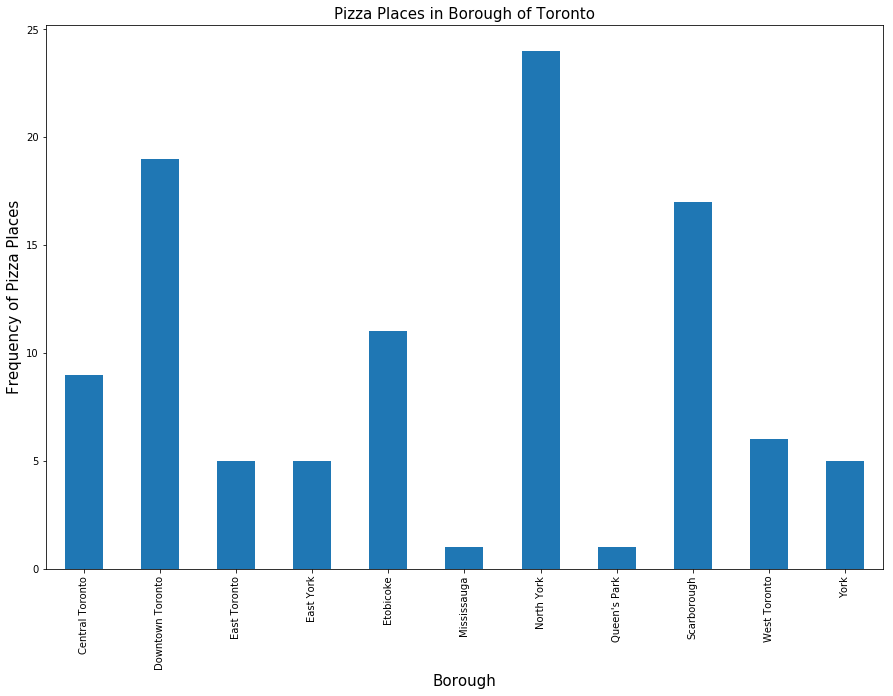

In [31]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15,10))
plt.title('Pizza Places in Borough of Toronto', fontsize=15)
plt.xlabel("Borough", fontsize=15)
plt.ylabel ("Frequency of Pizza Places", fontsize=15)
toronto_PizzaPlace_merged.groupby('Borough')['Pizza Place'].count().plot(kind='bar')
plt.show()

## Clustering Neighborhoods

#### Let's use the Elbow method to find the K to use for the number of clusters

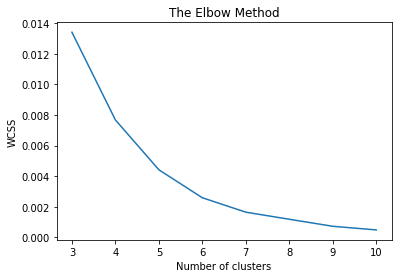

In [32]:
# Using the elbow method to find the optimal number of clusters
# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

toronto_PizzaPlace_Clustering = toronto_PizzaPlace.drop('Neighborhood', 1)


wcss = []

for i in range(3, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter= 50)
    kmeans.fit(toronto_PizzaPlace_Clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(3, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

#### From this map, we can see that 6 is the best K value.
#### So, we'll Run *k*-means to cluster the neighborhood into 6 clusters.

In [33]:
# set number of clusters
kclusters = 6

toronto_PizzaPlace_Clustering = toronto_PizzaPlace.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_PizzaPlace_Clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 0, 4, 1, 2, 1, 3, 4, 3, 3, 2, 0, 4, 3, 4, 0, 2, 3, 0, 4, 0, 0,
       0, 1, 0, 1, 2, 0, 2, 4, 0, 2, 0, 4, 2, 3, 4, 2, 5, 2, 1, 2, 3, 0,
       0, 0, 4, 4, 5, 0, 3, 0, 4, 3, 4, 0, 2, 3, 4, 1, 0, 2, 0, 0, 0, 4,
       1, 0, 0, 0, 2, 2, 4, 4, 4, 0, 4, 2, 2, 0, 2, 0, 0, 0, 4, 0, 4, 4,
       4, 4, 4, 0, 3, 0, 5, 4, 4, 1, 1, 1, 1, 0], dtype=int32)

In [34]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_PizzaPlace_Clustering_merged = toronto_PizzaPlace.copy()
# add clustering labels
toronto_PizzaPlace_Clustering_merged["Cluster Labels"] = kmeans.labels_
toronto_PizzaPlace_Clustering_merged.head()

,Neighborhood,Pizza Place,Cluster Labels
0,"Adelaide, King, Richmond",0.040000,4
1,Agincourt,0.016129,0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.041667,4
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.088235,1
4,"Alderwood, Long Branch",0.065217,2


In [35]:
# Now let's merge the Toronto Geodata and the Toronto Pizza Places data per Neighborhood with Cluster labels
toronto_PizzaPlace_Clustering_merged2 = pd.merge(df_Toronto_Geodata, toronto_PizzaPlace_Clustering_merged[['Neighborhood','Pizza Place', 'Cluster Labels']], on='Neighborhood')

toronto_PizzaPlace_Clustering_merged2.head()


,Postalcode,Latitude,Longitude,Borough,Neighborhood,Pizza Place,Cluster Labels
0,M1B,43.806686,-79.194353,Scarborough,"Rouge, Malvern",0.058824,2
1,M1C,43.784535,-79.160497,Scarborough,"Highland Creek, Rouge Hill, Port Union",0.000000,3
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill",0.121212,5
3,M1G,43.770992,-79.216917,Scarborough,Woburn,0.093750,1
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae,0.015152,0


In [36]:
# Let's sort the results by Cluster Labels
print(toronto_PizzaPlace_Clustering_merged2.shape)
toronto_PizzaPlace_Clustering_merged2.sort_values(["Cluster Labels"], inplace=True)
toronto_PizzaPlace_Clustering_merged2

(103, 7)


,Postalcode,Latitude,Longitude,Borough,Neighborhood,Pizza Place,Cluster Labels
51,M4X,43.667967,-79.367675,Downtown Toronto,"Cabbagetown, St. James Town",0.010000,0
27,M3C,43.725900,-79.340923,North York,"Flemingdon Park, Don Mills South",0.012346,0
71,M6A,43.718518,-79.464763,North York,"Lawrence Heights, Lawrence Manor",0.010000,0
70,M5X,43.648429,-79.382280,Downtown Toronto,"First Canadian Place, Underground city",0.010000,0
69,M5W,43.646435,-79.374846,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,0.010000,0
67,M5T,43.653206,-79.400049,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",0.020000,0
66,M5S,43.662696,-79.400049,Downtown Toronto,"Harbord, University of Toronto",0.010000,0
34,M4A,43.725882,-79.315572,North York,Victoria Village,0.017544,0
65,M5R,43.672710,-79.405678,Central Toronto,"The Annex, North Midtown, Yorkville",0.020000,0
38,M4G,43.709060,-79.363452,East York,Leaside,0.013333,0


#### Now, let's use the Folium Package to display the Neighborhoods by Cluster

In [37]:
import folium
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_PizzaPlace_Clustering_merged2['Latitude'], toronto_PizzaPlace_Clustering_merged2['Longitude'], toronto_PizzaPlace_Clustering_merged2['Neighborhood'], toronto_PizzaPlace_Clustering_merged2['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Clusters

In [38]:
# Cluster 0
toronto_PizzaPlace_Cluster0 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 0]
print(toronto_PizzaPlace_Cluster0.shape)
toronto_PizzaPlace_Cluster0

(33, 7)


,Postalcode,Latitude,Longitude,Borough,Neighborhood,Pizza Place,Cluster Labels
51,M4X,43.667967,-79.367675,Downtown Toronto,"Cabbagetown, St. James Town",0.010000,0
27,M3C,43.725900,-79.340923,North York,"Flemingdon Park, Don Mills South",0.012346,0
71,M6A,43.718518,-79.464763,North York,"Lawrence Heights, Lawrence Manor",0.010000,0
70,M5X,43.648429,-79.382280,Downtown Toronto,"First Canadian Place, Underground city",0.010000,0
69,M5W,43.646435,-79.374846,Downtown Toronto,Stn A PO Boxes 25 The Esplanade,0.010000,0
67,M5T,43.653206,-79.400049,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",0.020000,0
66,M5S,43.662696,-79.400049,Downtown Toronto,"Harbord, University of Toronto",0.010000,0
34,M4A,43.725882,-79.315572,North York,Victoria Village,0.017544,0
65,M5R,43.672710,-79.405678,Central Toronto,"The Annex, North Midtown, Yorkville",0.020000,0
38,M4G,43.709060,-79.363452,East York,Leaside,0.013333,0


In [39]:
# Cluster 1
toronto_PizzaPlace_Cluster1 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 1]
print(toronto_PizzaPlace_Cluster1.shape)
toronto_PizzaPlace_Cluster1

(11, 7)


,Postalcode,Latitude,Longitude,Borough,Neighborhood,Pizza Place,Cluster Labels
100,M9R,43.688905,-79.554724,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv...",0.095238,1
3,M1G,43.770992,-79.216917,Scarborough,Woburn,0.093750,1
6,M1K,43.727929,-79.262029,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",0.076923,1
7,M1L,43.711112,-79.284577,Scarborough,"Clairlea, Golden Mile, Oakridge",0.085714,1
8,M1M,43.716316,-79.239476,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",0.073171,1
11,M1R,43.750072,-79.295849,Scarborough,"Maryvale, Wexford",0.081633,1
24,M2R,43.782736,-79.442259,North York,Willowdale West,0.076923,1
35,M4B,43.706397,-79.309937,East York,"Woodbine Gardens, Parkview Hill",0.076923,1
28,M3H,43.754328,-79.442259,North York,"Bathurst Manor, Downsview North, Wilson Heights",0.075000,1
36,M4C,43.695344,-79.318389,East York,Woodbine Heights,0.085714,1


In [40]:
# Cluster 2
toronto_PizzaPlace_Cluster2 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 2]
print(toronto_PizzaPlace_Cluster2.shape)
toronto_PizzaPlace_Cluster2

(17, 7)


,Postalcode,Latitude,Longitude,Borough,Neighborhood,Pizza Place,Cluster Labels
92,M8Y,43.636258,-79.498509,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",0.060606,2
90,M8W,43.602414,-79.543484,Etobicoke,"Alderwood, Long Branch",0.065217,2
84,M6S,43.651571,-79.484450,West Toronto,"Runnymede, Swansea",0.055556,2
80,M6M,43.691116,-79.476013,York,"Del Ray, Keelesdale, Mount Dennis, Silverthorn",0.055556,2
94,M9B,43.650943,-79.554724,Etobicoke,"Cloverdale, Islington, Martin Grove, Princess ...",0.047619,2
79,M6L,43.713756,-79.490074,North York,"Downsview, North Park, Upwood Park",0.060606,2
95,M9C,43.643515,-79.577201,Etobicoke,"Bloordale Gardens, Eringate, Markland Wood, Ol...",0.054054,2
74,M6E,43.689026,-79.453512,York,Caledonia-Fairbanks,0.057143,2
0,M1B,43.806686,-79.194353,Scarborough,"Rouge, Malvern",0.058824,2
102,M9W,43.706748,-79.594054,Etobicoke,Northwest,0.055556,2


In [41]:
# Cluster 3
toronto_PizzaPlace_Cluster3 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 3]
print(toronto_PizzaPlace_Cluster3.shape)
toronto_PizzaPlace_Cluster3

(11, 7)


,Postalcode,Latitude,Longitude,Borough,Neighborhood,Pizza Place,Cluster Labels
96,M9L,43.756303,-79.565963,North York,Humber Summit,0.0,3
87,M7R,43.636966,-79.615819,Mississauga,Canada Post Gateway Processing Centre,0.0,3
16,M1X,43.836125,-79.205636,Scarborough,Upper Rouge,0.0,3
19,M2K,43.786947,-79.385975,North York,Bayview Village,0.0,3
97,M9M,43.724766,-79.532242,North York,"Emery, Humberlea",0.0,3
1,M1C,43.784535,-79.160497,Scarborough,"Highland Creek, Rouge Hill, Port Union",0.0,3
76,M6H,43.669005,-79.442259,West Toronto,"Dovercourt Village, Dufferin",0.0,3
9,M1N,43.692657,-79.264848,Scarborough,"Birch Cliff, Cliffside West",0.0,3
30,M3K,43.737473,-79.464763,North York,"CFB Toronto, Downsview East",0.0,3
53,M5A,43.654260,-79.360636,Downtown Toronto,Harbourfront,0.0,3


In [42]:
# Cluster 4
toronto_PizzaPlace_Cluster4 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 4]
print(toronto_PizzaPlace_Cluster4.shape)
toronto_PizzaPlace_Cluster4

(28, 7)


,Postalcode,Latitude,Longitude,Borough,Neighborhood,Pizza Place,Cluster Labels
68,M5V,43.628947,-79.394420,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.028571,4
45,M4P,43.712751,-79.390197,Central Toronto,Davisville North,0.030303,4
98,M9N,43.706876,-79.518188,York,Weston,0.041667,4
43,M4M,43.659526,-79.340923,East Toronto,Studio District,0.030000,4
57,M5G,43.657952,-79.387383,Downtown Toronto,Central Bay Street,0.030000,4
58,M5H,43.650571,-79.384568,Downtown Toronto,"Adelaide, King, Richmond",0.040000,4
42,M4L,43.668999,-79.315572,East Toronto,"The Beaches West, India Bazaar",0.030000,4
91,M8X,43.653654,-79.506944,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",0.033333,4
14,M1V,43.815252,-79.284577,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",0.041667,4
41,M4K,43.679557,-79.352188,East Toronto,"The Danforth West, Riverdale",0.043956,4


In [43]:
# Cluster 5
toronto_PizzaPlace_Cluster5 = toronto_PizzaPlace_Clustering_merged2.loc[toronto_PizzaPlace_Clustering_merged2['Cluster Labels'] == 5]
print(toronto_PizzaPlace_Cluster5.shape)
toronto_PizzaPlace_Cluster5

(3, 7)


,Postalcode,Latitude,Longitude,Borough,Neighborhood,Pizza Place,Cluster Labels
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood, Morningside, West Hill",0.121212,5
99,M9P,43.696319,-79.532242,Etobicoke,Westmount,0.125000,5
31,M3L,43.739015,-79.506944,North York,Downsview West,0.125000,5


## CONCLUSION

### To recap :

The stakeholders wanted to avoid unnecessary competition against existing Pizza places. So, they wanted to open their first Pizza restaurant in locations where there as less pizza restaurants.

We can see from the K-Mean clustering that *Cluster 3* is the cluster which has less Pizza Places.

### So, the best places to open their first Pizza Restaurant are the Neighborhoods from Cluster 3.